Compute the CPT for the FEV1, Unblocked FEV1, % Airway Blockage factor function

We'll apply what we've learned in uniform_x_uniform.ipynb to compute the CPT for the factor function which is the joint probability density function $f_{FEV_1}(Unblocked\ FEV1, \%Small\ Airway\ Blockage)$ 

In [3]:
import numpy as np
import pandas as pd
import scipy.integrate as integrate
from decimal import Decimal

In [43]:
# Let Unblocked FEV1 be a continuous random variable following a uniform distribution between a and b
def get_unblocked_fev1(a, b):
    return np.random.uniform(a, b)

# Let % Small Airway blockage be a continuous randome variable following a uniform distribution between a and b
def get_small_airway_blockage(a, b):
    return np.random.uniform(a, b)

# Let FEV1 be the product of Unblocked FEV1 and (1 - % Small Airway blockage)
# FEV1 is a continuous random variable following a uniform distribution between 0 and 6
def get_fev1(unblocked_fev1,small_airway_blockage ):
    # 0% Small Airway blockage implies that FEV1 = Unblocked FEV1
    # 100% Small Airway blockage implies that FEV1 = 0
    fev1 = unblocked_fev1 * (1-small_airway_blockage)
    return pd.DataFrame({
        "Unblocked FEV1": [unblocked_fev1], 
        "Small airway blockage": [small_airway_blockage], 
        "FEV1": [fev1]
    })

# We can generate a sample of FEV1 values and put the results in a dataframe
def generate_fev1_sample(u1, u2, s1, s2, n=10000):
    df = get_fev1(get_unblocked_fev1(u1, u2), get_small_airway_blockage(s1, s2))
    for _ in range(n):
        df = pd.concat([df, get_fev1(get_unblocked_fev1(u1, u2), get_small_airway_blockage(s1, s2))])
    return df

In [32]:
generate_fev1_sample(2, 3, 0, 0.1, 10)

,Unblocked FEV1,Small airway blockage,FEV1
0,2.472564,0.033810,0.083597
0,2.262469,0.084106,0.190287
0,2.640810,0.055123,0.145569
0,2.278770,0.076320,0.173915
0,2.948704,0.074172,0.218710
0,2.028058,0.090480,0.183498
0,2.359519,0.031087,0.073350
0,2.378401,0.093843,0.223197
0,2.807099,0.080824,0.226881
0,2.199336,0.092026,0.202395


The function `generate_fev1_sample()` can be used to get an estimate of the joint probability distribution of Unblocked FEV1 and % Small Airway blockage, which is also the PDF of FEV1.

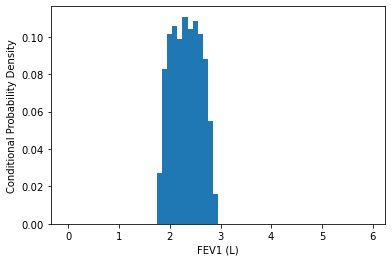

In [53]:
u1=2; u2=3; s1=0; s2=0.1
b2=1-s1; b1=1-s2

fev1_samples = generate_fev1_sample(u1, u2, s1, s2)["FEV1"]
# Histogram up the sample values into bins of 0.1 units between 0 and 6
hist, bins = np.histogram(fev1_samples, bins=np.arange(0, 6.1, 0.1))
# Normalize the histogram to get the probability of each bin of FEV1
hist_norm = hist / len(fev1_samples)
# Plot the histogram
import matplotlib.pyplot as plt
plt.bar(bins[:-1], hist_norm, width=0.1)
# Set y label to Probability Density Function, set x label to FEV1 (L)
plt.ylabel("Conditional Probability Density")
plt.xlabel("FEV1 (L)")
plt.show()

In [7]:
# Closed form solution
def p_uniform(x, a, b):
    if a <= x and x <= b:
        return 1/(b-a)
    else:
        return 0

def p_fev1(x, a, b, c, d):
    if a*d < c*b:
        if x > a*c and x < a*d:
            return np.log(x/(a*c))
        elif x >= a*d and x <= c*b:
            return np.log(d/c)
        elif x > c*b and x < b*d:
            return np.log(d*b/x)
        else:
            return 0
    else:
        # exchange X and Y
        return - p_fev1(x, c, d, a, b)

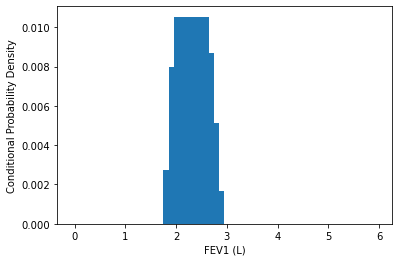

In [54]:
fev1_bins=np.arange(0, 6.1, 0.1)

fev1_hist=[]
for i in range(0,len(fev1_bins)-1):
    fev1_low = fev1_bins[i]
    fev1_up = fev1_bins[i+1]
    
    val, abserr = integrate.quad(p_fev1, fev1_low, fev1_up, args=(b1, b2, u1, u2))
    fev1_hist.append(val)

plt.bar(fev1_bins[:-1], fev1_hist, width=0.1)
# Set y label to Probability Density Function, set x label to FEV1 (L)
plt.ylabel("Conditional Probability Density")
plt.xlabel("FEV1 (L)")
plt.show()

Compute the Conditional Probability Table

Since we don't know how to do inference on continuous probability distributions, we need discretize the above model and compute the CPT.

Here's how to discretise the model by sampling
1. Define bins for each variable
2. Add up the bin to which the variable corresponds to
3. Group by the same set of inputs, and outputs and count the number of occurences of each groups
4. Normalize by the total amount of occurences. 

The CPT has three dimensions. For each possible set of bins, it will associate a probability.

Knowing that $P(x \in FEV_1\ bin) = \frac{\#FEV_1\ bin\ outcomes}{\#outcomes}$, we can agglomerate the sample values into bins (i.e. histogram up) and use the bin counts to estimate the CPT of FEV1, Unblocked FEV1, and % Small Airway blockage

In [64]:
# Given a value and an array of bins, this returns the bin that the value falls into
def get_bin_for_value(value, bins):
  hist, bins = np.histogram(value, bins=bins)
  if (value == bins[-1]): 
    return "not allowed"

  idx = np.where(hist == 1)[0].item()
  lower_idx = bins[idx].item()
  upper_idx = bins[idx+1].item()
  return "[{}; {}[".format(lower_idx, upper_idx)

In [65]:
df_binned_sampled = generate_fev1_sample(10000)

# We must use range, and then convert to floats, otherwise we end up with 0.1, 0.2, 0.30000000000000004, etc.
# 2.0-2.2, 2.2-2.4, 2.4-2.6, etc.
bins_unblocked_fev1 = [x/10 for x in range(20, 60+1, 20)]
# 0-10%, 10-20%, 20-30%, etc.
bins_small_airway_blockage = [x/10 for x in range(0, 10+1, 2)]
# 0.0-0.2, 0.2-0.4, 0.4-0.6, etc.
bins_fev1 = [x/10 for x in range(0, 60+1, 20)] 

df_binned_sampled["Unblocked FEV1 bin"] = df_binned_sampled["Unblocked FEV1"].apply(lambda x: get_bin_for_value(x, bins_unblocked_fev1))
df_binned_sampled["Small airway blockage bin"] = df_binned_sampled["Small airway blockage"].apply(lambda x: get_bin_for_value(x, bins_small_airway_blockage))
df_binned_sampled["FEV1 bin"] = df_binned_sampled["FEV1"].apply(lambda x: get_bin_for_value(x, bins_fev1))

In [66]:
df_cpt = df_binned_sampled.groupby(["Unblocked FEV1 bin", "Small airway blockage bin", "FEV1 bin"]).size().reset_index(name="count")
df_cpt["p"] = df_cpt.apply(lambda x: x["count"] / len(df_binned_sampled), axis=1)

In [67]:
df_cpt

,Unblocked FEV1 bin,Small airway blockage bin,FEV1 bin,count,p
0,[2.0; 4.0[,[0.0; 0.2[,[0.0; 2.0[,94,0.009399
1,[2.0; 4.0[,[0.0; 0.2[,[2.0; 4.0[,830,0.082992
2,[2.0; 4.0[,[0.2; 0.4[,[0.0; 2.0[,456,0.045595
3,[2.0; 4.0[,[0.2; 0.4[,[2.0; 4.0[,556,0.055594
4,[2.0; 4.0[,[0.4; 0.6[,[0.0; 2.0[,921,0.092091
5,[2.0; 4.0[,[0.4; 0.6[,[2.0; 4.0[,84,0.008399
6,[2.0; 4.0[,[0.6; 0.8[,[0.0; 2.0[,964,0.096390
7,[2.0; 4.0[,[0.8; 1.0[,[0.0; 2.0[,1030,0.102990
8,[4.0; 6.0[,[0.0; 0.2[,[2.0; 4.0[,237,0.023698
9,[4.0; 6.0[,[0.0; 0.2[,[4.0; 6.0[,779,0.077892


In [68]:
print("Bins covered during sampling")
print("{} for Smart airway blockage covered during ".format(df_cpt["Small airway blockage bin"].nunique()))
print("{} for Unblocked FEV1 covered during ".format(df_cpt["Unblocked FEV1 bin"].nunique()))
print("{} for FEV1 covered during ".format(df_cpt["FEV1 bin"].nunique()))


Bins covered during sampling
5 for Smart airway blockage covered during 
2 for Unblocked FEV1 covered during 
3 for FEV1 covered during 


In [69]:
print("Total number of bins in full CPT")
# Number of bins for Unblocked FEV1
print("{} bins for Unblocked FEV1".format(len(bins_unblocked_fev1)-1))
# Number of bins for Small Airway Blockage
print("{} bins for Small Airway Blockage".format(len(bins_small_airway_blockage)-1))
# Number of bins for FEV1
print("{} bins for FEV1".format(len(bins_fev1)-1))
# Number of bins for Unblocked FEV1 * Number of bins for Small Airway Blockage * Number of bins for FEV1
print("{} unique triplets of {{Unblocked FEV1; Small Airway Blockage; FEV1}}".format((len(bins_unblocked_fev1)-1) * (len(bins_small_airway_blockage)-1) * (len(bins_fev1)-1)))

Total number of bins in full CPT
2 bins for Unblocked FEV1
5 bins for Small Airway Blockage
3 bins for FEV1
30 unique triplets of {Unblocked FEV1; Small Airway Blockage; FEV1}


Main issues: creating the CPTs by sampling 
* Takes an gigantic amount of time: 40s to generate
* Is inaccurate. Under the previous settings, the sets of unique inputs/outpus has 9k elements



In [70]:
# Let's implement the closed form solution for FEV1

# Closed form solution
# Compare it with the samples for particular values
# Create CPT from closed form solution

# Create data structures for the milestone model
* variable node message: column vector
* factor node message: column vector
* CPT: matrix (childs, parents)

In Pandas' dot product `df.dot(other) or df @ other`, other can be a dataframe, a series, an np.array.

Pandas vs NumPy: Pandas is more user-friendly, but NumPy is faster. Pandas has a lot more options for handling missing data, but NumPy has better performance on large datasets.

Flow to create the CPT(childs, parents)
1. Create a list of bins for the child variables, and for the parent variables
2. Using the dimensions for this list, generate the CPT matrix
3. Fill the matrix with the values from the closed form solution

In [21]:

def continuous_interval_to_bin(a, b, width):
  # Don't use np.arange with floats because of floating point arithmetic issues (since floating points
  # are saved in binary) https://docs.python.org/3/tutorial/floatingpoint.html
  # Not working for width < 0.1
  "We use b+witdh to include b in the last bin"
  adjusted_width = round(width*10)
  return [x/10 for x in np.arange(a*10, b*10+adjusted_width, adjusted_width)]

class variableNode: 
    def __init__(self, name, a, b, bin_witdh):
        self.name = name
        self.a = a
        self.b = b
        self.bin_witdh = bin_witdh
        self.bins = continuous_interval_to_bin(a, b, bin_witdh)

    @staticmethod
    def sample(self):
        return np.random.uniform(self.a, self.b)
        
    @staticmethod
    def get_name(self):
        return self.name

# Conditional probability density, which is the product of the PDFs of Unblocked FEV1 and Small Airway Blockage
def p_fev1(x, u1, u2, s1, s2):
    # if x in [a*p, b*k],
    if u1*s1 <= x and x <= u2*s2:
        return 1/(s2-s1)*(u2-u1)*np.log(s2/x)
    else:
        return 0
    
def get_outcome_range(u1, u2, s1, s2):
    return np.array([u1*s1, u2*s2])

In [16]:
unblocked_fev1 = variableNode("Unblocked FEV1", 2, 6, 0.2)
small_airway_blockage = variableNode("Small airway blockage", 0, 1, 0.1)
fev1 = variableNode("FEV1", 0, 6, 0.2)

In [20]:
# P(fev1 | unblocked_fev1, small_airway_blockage) can be computed with the closed form solution
cpt = np.zeros((len(unblocked_fev1.bins)-1, len(small_airway_blockage.bins)-1, len(fev1.bins)-1))

for i in range(len(unblocked_fev1.bins)-1):
  # Take a bin in Unblocked FEV1
  u_low = unblocked_fev1.bins[i]
  u_up = unblocked_fev1.bins[i+1]

  for j in range(len(small_airway_blockage.bins)-1):
    # Take a bin in Small Airway Blockage
    b_low = small_airway_blockage.bins[j]
    b_up = small_airway_blockage.bins[j+1]

    # Get the range after multiplying the two variables
    outcome_range = get_outcome_range(u_low, u_up, b_low, b_up)

    for k in range(len(fev1.bins)-1):
        # Take a bin in FEV1
        fev1_low = fev1.bins[k]
        fev1_up = fev1.bins[k+1]
        
        # Get the inner intersection of outcome_range and [fev1_low, fev1_up]
        # Compute P(fev1 | unblocked_fev1, small_airway_blockage)
        if (outcome_range[0] >= fev1_low and outcome_range[0] < fev1_up) or (outcome_range[1] > fev1_low and outcome_range[1] <= fev1_up):
            # The intersection is not empty
            val, abserr = integrate.quad(p_fev1, -np.inf, np.inf, args=(u_low, u_up, b_low, b_up))
            print(val)
            cpt[i, j, k] = val
        else: 
            # The intersection is empty
            cpt[i, j, k] = 0

0.09307875691152488
0.09307875691152488
-0.21384247714213242
-0.21384247714213242
-0.2906180543339968
-0.2906180543339968
-0.34112682471497846
-0.34112682471497846
-0.38260038600139445
-0.38260038600139445
-0.41987615186946875
-0.41987615186946875
-0.45485706802383535
-0.45485706802383535
-0.4884457062064377
-0.4884457062064377
0.0
0.0
0.0
0.0
0.05977500624985452
0.05977500624985452
-0.2785135067841994
-0.2785135067841994
-0.36364179983756295
-0.36364179983756295
0.0
0.0
-0.46617266013369973
-0.46617266013369973
0.0
0.0
-0.5470053156175995
-0.5470053156175995
0.0
0.0
0.0
0.0
-0.6571863374102391
-0.6571863374102391
0.023134048616548265
0.023134048616548265
-0.34621755587099323
-0.34621755587099323
-0.43939438271170034
-0.43939438271170034
-0.5010510018027879
-0.5010510018027879
-0.551865037985753
-0.551865037985753
-0.5976424751690923
-0.5976424751690923
-0.6406656384153914
-0.6406656384153914
0.0
0.0
0.0
0.0
-0.7617920016845413
-0.7617920016845413
-0.01658687362144954
-0.01658687362144

/var/folders/zq/v2r6yn111s3gpdf8lzf72xvw0000gn/T/ipykernel_74951/1362757509.py:28: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  val, abserr = integrate.quad(p_fev1, -np.inf, np.inf, args=(u_low, u_up, b_low, b_up))



-0.1521672923656765
-0.6435322642330559
-0.6435322642330559
-0.7666641852842414
-0.7666641852842414
-0.8477692014000544
-0.8477692014000544
-0.9144178858142694
-0.9144178858142694
0.0
0.0
-1.0306105498271154
-1.0306105498271154
-1.0846433432817462
-1.0846433432817462
0.0
0.0
0.0
0.0
-0.20227236866273882
-0.20227236866273882
-0.7237175295696758
-0.7237175295696758
-0.8539150674075958
-0.8539150674075958
0.0
0.0
-1.0096431274051187
-1.0096431274051187
0.0
0.0
-1.1318376046031209
-1.1318376046031209
0.0
0.0
0.0
0.0
0.0
0.0
-0.2546008105187773
-0.2546008105187773
-0.8059952227046856
-0.8059952227046856
-0.9431274532146897
-0.9431274532146897
0.0
0.0
-1.106568010791345
-1.106568010791345
0.0
0.0
-1.234502327516303
-1.234502327516303
0.0
0.0
0.0
0.0
0.0
0.0
-0.3090354888984873
-0.3090354888984873
-0.8902620253253388
-0.8902620253253388
-1.034211809553428
-1.034211809553428
-1.1282547601593378
-1.1282547601593378
-1.2051305974969249
-1.2051305974969249
-1.2740307955447505
-1.2740307955447505